In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd()
debug = False

if debug:
    nrows = 600
else:
    nrows = None

In [3]:
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "4" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "4" # export NUMEXPR_NUM_THREADS=6

In [4]:
train_start_time = '2019-01-01 00:00:00'
train_end_time = '2019-09-10 21:59:59'
test_start_time = '2019-09-10 22:00:00'
test_end_time = '2020-01-01 00:00:00'

## Import Dataset

In [6]:
prod = 'BTCUSD'
data = pd.read_csv(path + '/clean_data/hourly%s-H1.csv' % prod, nrows=nrows, sep='\t')

In [7]:
data.head(2)

,Date,Time,Open,High,Low,Close,Volume
0,20170508,00:00:00,1555.1,1614.5,1544.2,1593.3,252
1,20170508,01:00:00,1593.3,1627.5,1556.3,1593.4,296


In [8]:
# using `Open` to calculate log daily return
data['y'] = np.log(data['Open']).diff()
data['ds'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'], format='%Y%m%d %H:%M:%S')
data.index = pd.DatetimeIndex(data['ds'])

useCols = ['y', 'ds']
data = data[useCols]
data.dtypes

y            float64
ds    datetime64[ns]
dtype: object

In [9]:
train = data.loc[train_start_time: train_end_time]
test = data.loc[test_start_time: test_end_time]

In [10]:
print(train.shape)
print(train.dtypes)
train.head(2)

(4317, 2)
y            float64
ds    datetime64[ns]
dtype: object


,y,ds
ds,,
2019-01-01 22:00:00,0.012597,2019-01-01 22:00:00
2019-01-01 23:00:00,-0.000137,2019-01-01 23:00:00


In [11]:
train.tail(2)

,y,ds
ds,,
2019-09-10 20:00:00,-0.017766,2019-09-10 20:00:00
2019-09-10 21:00:00,0.003971,2019-09-10 21:00:00


In [12]:
print(test.shape)
print(test.dtypes)
test.head(2)

(1899, 2)
y            float64
ds    datetime64[ns]
dtype: object


,y,ds
ds,,
2019-09-10 22:00:00,0.004374,2019-09-10 22:00:00
2019-09-10 23:00:00,-0.001406,2019-09-10 23:00:00


In [13]:
test.tail(2)

,y,ds
ds,,
2019-12-31 21:00:00,0.000056,2019-12-31 21:00:00
2019-12-31 22:00:00,0.001508,2019-12-31 22:00:00


# Visualization

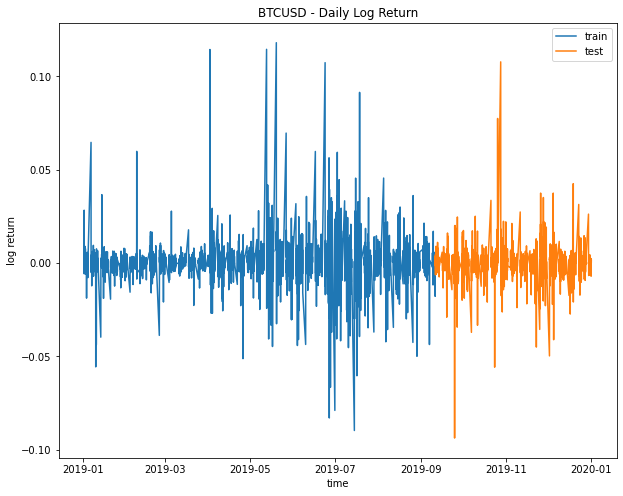

In [14]:
plt.figure(figsize=(10, 8))
plt.title("%s - Daily Log Return" % prod)
plt.plot(train['ds'].dt.to_pydatetime(), train['y'], label='train')
plt.plot(test['ds'], test['y'], label='test')
plt.xlabel('time')
plt.ylabel('log return')
plt.savefig(path + '/result/%s-trend_seasonality.png' % prod)
plt.legend()

## Cross Validation

In [15]:
'''
defult parameters={
    'growth': 'linear',
    'changepoints': None,
    'n_changepoints': 25,
    'changepoint_range': 0.8,
    'yearly_seasonality': 'auto',
    'weekly_seasonality': 'auto',
    'daily_seasonality': 'auto',
    'holidays': None,
    'seasonality_mode': 'additive',
    'seasonality_prior_scale': 10.0,
    'holidays_prior_scale': 10.0,
    'changepoint_prior_scale': 0.05,
    'mcmc_samples': 0,
    'interval_width': 0.80,
    'uncertainty_samples': 1000,
    'stan_backend': None
}
'''
n_folds = 5
params = {}

In [16]:
tscv = TimeSeriesSplit(n_splits=n_folds)
cvGenerator = tscv.split(train)
cvResult = {}


for i in tqdm_notebook(range(n_folds)):
    cvResult[i] = {}
    
    # time series cross validation split
    trainIndex, valIndex = next(cvGenerator)
    cvResult[i]['train_index'] = trainIndex
    cvResult[i]['valid_index'] = valIndex
    
    
    # modelling    
    cvResult[i]['model'] = Prophet(**params)
    cvResult[i]['model'].fit(train.iloc[trainIndex])
    
    
    # predicting on validation set
    future = train[['ds']].iloc[trainIndex.tolist() + valIndex.tolist()]
    forecast = cvResult[i]['model'].predict(future)
    cvResult[i]['predict'] = forecast
    cvResult[i]['train_perf'] = mean_squared_error(
        train.iloc[trainIndex]['y'], 
        forecast['yhat'].iloc[trainIndex]
    )
    cvResult[i]['valid_perf'] = mean_squared_error(
        train.iloc[valIndex]['y'], 
        forecast['yhat'].iloc[valIndex]
    )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [17]:
with open(path + '/result/%s-cv_results.pkl' % prod, 'wb') as f:
    pickle.dump(cvResult, f, pickle.HIGHEST_PROTOCOL)

In [18]:
os.system('tar zcvf ' + path + '/result/%s-cv_results' % prod + '.tar.gz ' + path + '/result/%s-cv_results.pkl' % prod)

0

In [19]:
val_perf = []
val_index = []
for k, vDict in cvResult.items():
    val_perf.append(vDict['valid_perf'])
    val_index.append((vDict['valid_index'][0], vDict['valid_index'][-1]))

pd.Series(val_index)

0     (722, 1440)
1    (1441, 2159)
2    (2160, 2878)
3    (2879, 3597)
4    (3598, 4316)
dtype: object

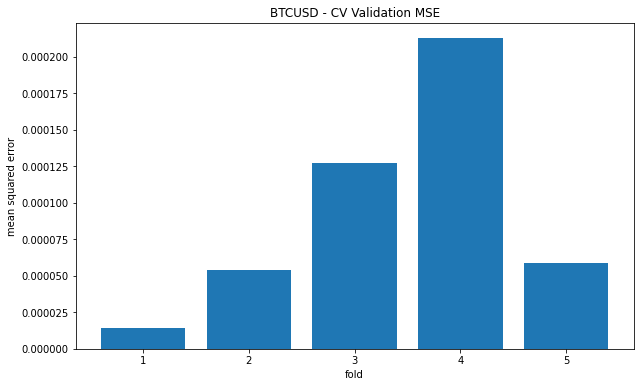

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(list(range(1, 6)), val_perf)
plt.title('%s - CV Validation MSE' % prod)
plt.xlabel('fold')
plt.ylabel('mean squared error')
plt.savefig(path + '/result/%s-cv_perf.png' % prod)

## Train Final Model 

In [21]:
model_name = '%s-final_model-' % prod + str(time.time())

In [22]:
params = {}
final_model = Prophet(**params)
final_model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [23]:
with open(path + '/result/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(final_model, f, pickle.HIGHEST_PROTOCOL)

In [24]:
os.system('tar zcvf ' + path + '/result/' + model_name + '.tar.gz ' + path + '/result/' + model_name + '.pkl')

0

In [25]:
# with open(path + '/result/final_model-1588395903.6457782.pkl', 'rb') as f:
#     final_model = pickle.load(f)

In [26]:
future = pd.concat([train[['ds']], test[['ds']]], axis=0)
print(future.index)
future.dtypes

DatetimeIndex(['2019-01-01 22:00:00', '2019-01-01 23:00:00',
               '2019-01-02 00:00:00', '2019-01-02 01:00:00',
               '2019-01-02 02:00:00', '2019-01-02 03:00:00',
               '2019-01-02 04:00:00', '2019-01-02 05:00:00',
               '2019-01-02 06:00:00', '2019-01-02 07:00:00',
               ...
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-31 22:00:00'],
              dtype='datetime64[ns]', name='ds', length=6216, freq=None)


ds    datetime64[ns]
dtype: object

In [27]:
forecast = final_model.predict(future)
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 22:00:00,0.000275,-0.010682,0.011728,0.000275,0.000275,0.000013,0.000013,0.000013,0.000248,0.000248,0.000248,-0.000235,-0.000235,-0.000235,0.0,0.0,0.0,0.000288
1,2019-01-01 23:00:00,0.000276,-0.011904,0.011900,0.000276,0.000276,0.000016,0.000016,0.000016,0.000247,0.000247,0.000247,-0.000230,-0.000230,-0.000230,0.0,0.0,0.0,0.000292


In [28]:
forecast.to_csv(path + '/result/%s-forecast_df.csv' % prod, index=False)

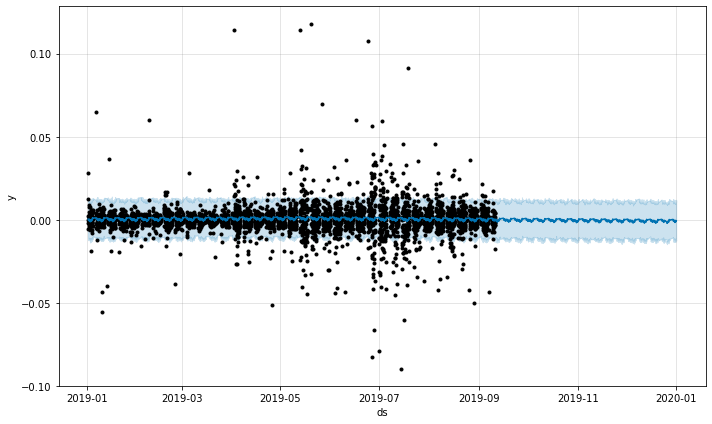

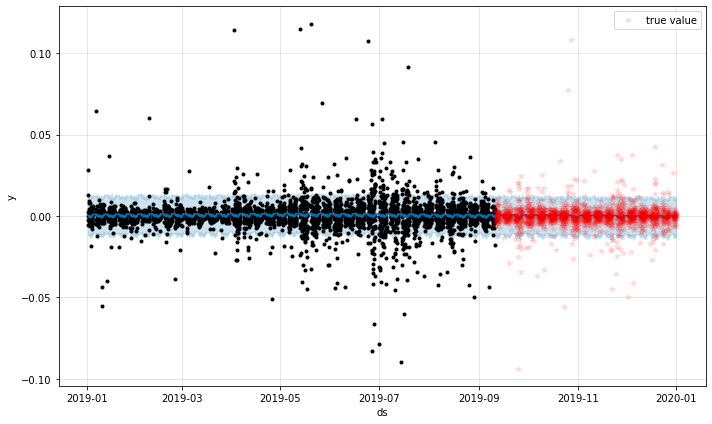

In [29]:
final_model.plot(forecast)
final_model.plot(forecast)
plt.plot(test['ds'], test['y'], 'r*', alpha=0.1, label='true value')
plt.savefig(path + '/result/%s-predict_plot.png' % prod)
plt.legend()

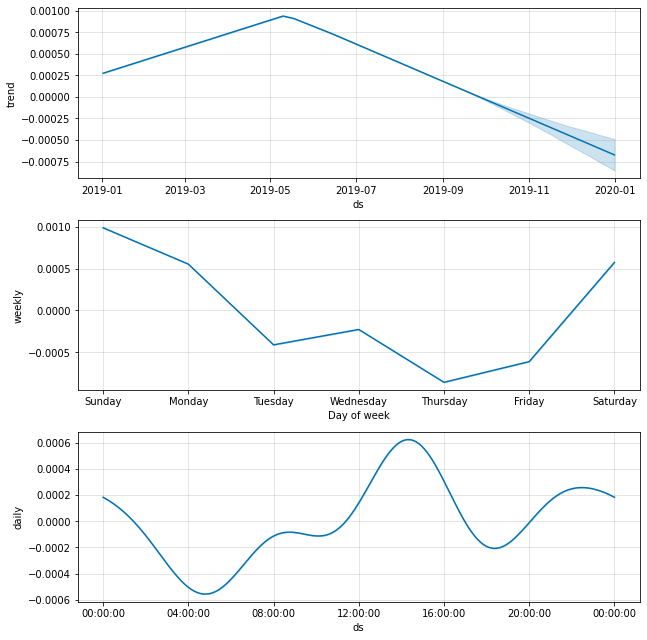

In [30]:
final_model.plot_components(forecast)
plt.savefig(path + '/result/%s-trend_seasonality.png' % prod)
plt.show()

In [31]:
trainIndex = train.index.values.tolist()
testIndex = test.index.values.tolist()

print('final training error:')
print(mean_squared_error(
    train['y'], 
    forecast['yhat'].iloc[:len(trainIndex)]
))

print('\nfinal testing error:')
print(mean_squared_error(
    test['y'], 
    forecast['yhat'].iloc[-len(testIndex):]
))

final training error:
8.23938514903532e-05

final testing error:
5.449232608440001e-05
